In [1]:
from elasticsearch import Elasticsearch
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
import joblib

warnings.filterwarnings('ignore')

In [2]:
es = Elasticsearch(hosts = ["http://79.125.3.215:9200"])

query = {
    "query": {
        "match_all": {}
    },
    "size": 1000  # Adjust batch size as per your requirements
}

scroll = es.search(index="asurion", body=query, scroll="5m")
scroll_id = scroll["_scroll_id"]

hits = scroll["hits"]["hits"]
data = [hit["_source"] for hit in hits]

while len(hits) > 0:
    scroll = es.scroll(scroll_id=scroll_id, scroll="5m")
    hits = scroll["hits"]["hits"]
    data.extend([hit["_source"] for hit in hits])

df = pd.DataFrame(data)

In [3]:
df["text"] = df["titre"] + " " + df["comment"]
df["target"] = df["stars"].str[6]
df = df[["text", "target"]].copy()
df = df.dropna()
df["target"] = df["target"].astype(int)

In [4]:
def delete_punctiation(df, comment_col):
    """
    Removes punctuation from the specified column of a DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame containing the text column.
        comment_col (str): The name of the column to remove punctuation from.

    Returns:
        None. The DataFrame is modified in-place.

    """
    pattern = r'[^a-zA-Z0-9\s]'
    df[comment_col] = df[comment_col].replace(pattern, ' ', regex=True)
    df[comment_col] = df[comment_col].str.replace('  ', ' ')


def truncate_text_column(df, column):
    df[column] = df[column].apply(lambda x: ' '.join(x.split()[:499]))
    return df


def text_cleaner(column):
    df[column] = df[column].str.lower() \
                            .str.strip() \
                            .str.replace(r'\s+', ' ')


In [5]:
text_cleaner("text")
delete_punctiation(df, "text")
truncate_text_column(df, 'text')

,text,target
0,excellent service with any insurance claim you...,5
1,everything went very well everything went very...,5
2,online system is not working this used to be m...,1
3,amazing customer service my customer care pers...,5
4,the service tech just showed up to the service...,3
...,...,...
91768,great service and fast very fast service and h...,5
91769,great service i got the phone the next day as ...,5
91770,great easy to fill out and quick on delivery,5
91771,replacement cost then cost of a rebuilt phone ...,4


# Divive data into train and test

In [6]:
X = df["text"]
y = df["target"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 1,
                                                    shuffle = True,
                                                    stratify = y)

# Training

In [7]:
# Train the classifier
clf = Pipeline([
    ('vectorizer', CountVectorizer()),  # Convert text to numerical features using a Bag-of-Words approach
    ('classifier', MultinomialNB())  # Train a Multinomial Naive Bayes classifier
])

clf.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', MultinomialNB())])

# Prediction

In [8]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

# Evaluation

              precision    recall  f1-score   support

           1       0.59      0.88      0.70      1623
           2       0.20      0.04      0.06       426
           3       0.24      0.11      0.15       604
           4       0.40      0.32      0.36      1539
           5       0.93      0.94      0.93     13834

    accuracy                           0.83     18026
   macro avg       0.47      0.46      0.44     18026
weighted avg       0.81      0.83      0.82     18026



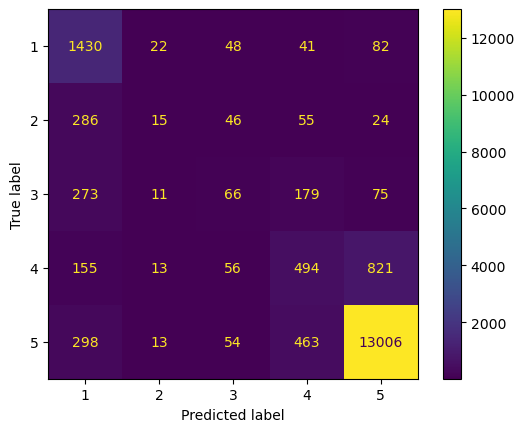

In [9]:
print(classification_report(y_test, y_pred_test))

plot_confusion_matrix(clf, X_test, y_test)
plt.show()

# Save and use the trained model

In [10]:
# save the trained model as a joblib file
joblib.dump(clf, 'mnb_model.joblib')

# load the saved model
loaded_clf = joblib.load('mnb_model.joblib')

# use the saved model on the test data
loaded_clf.predict(X_test)

array([5, 5, 5, ..., 5, 5, 5])

# Test it on personal comments

In [11]:
d = {'text': ["excellent service with any insurance claim you obviously have to explain the damage and click through the fraud acknowledgements, etc. that was not difficult at all.after that, the process was slick slick slick. the claim was filed late on a thursday afternoon and the replacement arrived on the friday morning.clear instructions the whole way and a very simple process",
                 "i never received the phone. you sent me a note last thursday that it was on its way. today is late tuesday night. still no phone. really frustrating.",
                 "absolutely disgusted with asurion - not trustworthy, no integrity i am completely disgusted with your company. a cell phone is an essential part of communication, and it is unacceptable for a simple glass replacement to take more than two weeks. from the first scheduled meeting to have the tech come to my home to repair (note that i had to reschedule appointments to be home), they canceled an hour after the scheduled arrival time. service truck was in the shop, multiple reschedule attempts - all failed to have the tech come to my home to fix the issue. five times after they were supposed to arrive, they cancelled! unacceptable. adam with ubreakifix. i finally caved and called at&t for assistance. they helped me get an appointment scheduled by contacting your company on my behalf... this time, there was no rescheduling; they simply did not show up, no call, no text.when i called, the asurion tech shipped the phone, promising that i would receive it the next day via fedex - lie, it arrived two days later. this has been the worst experience - your company's customer service is worse than comcast/xfinity's. satan trained ineffective employees. you're the worst!"]}

results_check = pd.DataFrame(d, columns=['text'])
results_check

,text
0,excellent service with any insurance claim you...
1,i never received the phone. you sent me a note...
2,absolutely disgusted with asurion - not trustw...


In [12]:
text_cleaner("text")
delete_punctiation(results_check, "text")
truncate_text_column(results_check, 'text')

,text
0,excellent service with any insurance claim you...
1,i never received the phone you sent me a note ...
2,absolutely disgusted with asurion not trustwor...


In [13]:
loaded_clf.predict(results_check["text"])

array([5, 1, 1])

# Retrain model on all data and save it

In [14]:
clf_final = Pipeline([
    ('vectorizer', CountVectorizer()),  # Convert text to numerical features using a Bag-of-Words approach
    ('classifier', MultinomialNB())  # Train a Multinomial Naive Bayes classifier
])

clf_final.fit(X, y)
# save the trained model as a joblib file
joblib.dump(clf_final, 'mnb_final_model.joblib')

['mnb_final_model.joblib']